In [1]:
import os.path
import numpy as np
import math
import cv2
import dlib
import aflw
import cv2
import matplotlib.pyplot as plt
from keras.models import model_from_yaml
from keras import backend as K
from PIL import Image as pil_image

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_img(path, grayscale=False, target_size=None, bbox=None):
    img = pil_image.open(path)
    if bbox:
        img = img.crop(bbox)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    if target_size:
        wh_tuple = (target_size[1], target_size[0])
        if img.size != wh_tuple:
            img = img.resize(wh_tuple)
    return img

def img_to_array(img, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x

def _scale_down_image(img, max_img_size):
    org_h, org_w = img.shape[0:2]
    h, w = img.shape[0:2]
    if max_img_size[0] < w:
        h *= float(max_img_size[0]) / float(w)
        w = max_img_size[0]
    if max_img_size[1] < h:
        w *= float(max_img_size[1]) / float(h)
        h = max_img_size[1]
    # Apply resizing
    if h == org_h and w == org_w:
        resize_scale = 1
    else:
        resize_scale = float(org_h) / float(h)  # equal to `org_w / w`
        img = cv2.resize(img, (int(w), int(h)))
    return img, resize_scale

def selective_search_dlib(img, max_img_size=(500, 500),
                          kvals=(50, 200, 2), min_size=2200, check=True,
                          debug_window=False):
    if debug_window:
        org_img = img
    org_h, org_w = img.shape[0:2]

    # Resize the image for speed up
    img, resize_scale = _scale_down_image(img, max_img_size)

    # Selective search
    drects = []
    dlib.find_candidate_object_locations(img, drects, kvals=kvals,
                                         min_size=min_size)
    rects = [(int(drect.left() * resize_scale),
              int(drect.top() * resize_scale),
              int(drect.width() * resize_scale),
              int(drect.height() * resize_scale)) for drect in drects]

    # Check the validness of the rectangles
    if check:
        if len(rects) == 0:
            logger.error('No selective search rectangle '
                         '(Please tune the parameters)')
        for rect in rects:
            x, y = rect[0], rect[1]
            w, h = rect[2], rect[3]
            x2, y2 = x + w, y + h
            if x < 0 or y < 0 or org_w < x2 or org_h < y2 or w <= 0 or h <= 0:
                logger.error('Invalid selective search rectangle, rect:{}, '
                             'image:{}'.format(rect, (org_h, org_w)))

    # Debug window
    if debug_window:
        for rect in rects:
            p1 = (rect[0], rect[1])
            p2 = (rect[0] + rect[2], rect[1] + rect[3])
            cv2.rectangle(org_img, p1, p2, (0, 255, 0))
        cv2.imshow('selective_search_dlib', org_img)
        cv2.waitKey(0)

    return rects

def standardize(x, samplewise_center=True, samplewise_std_normalization=True, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    if data_format == 'channels_first':
        channel_axis = 1
        row_axis = 2
        col_axis = 3
    if data_format == 'channels_last':
        channel_axis = 3
        row_axis = 1
        col_axis = 2
            
    img_channel_axis = channel_axis - 1
    if samplewise_center:
        x -= np.mean(x, axis=img_channel_axis, keepdims=True)
    if samplewise_std_normalization:
        x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)
    return x

def img_to_array(img, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
        
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)

    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x

def get_img(path, target_size, bbox):
    img = load_img(path, target_size=target_size, bbox=bbox)
    img_array = img_to_array(img)
    img_array = standardize(img_array)
    return img_array


Todas las regiones generadas con SS/NMS:

67 regiones propuestas luego de SS/NMS


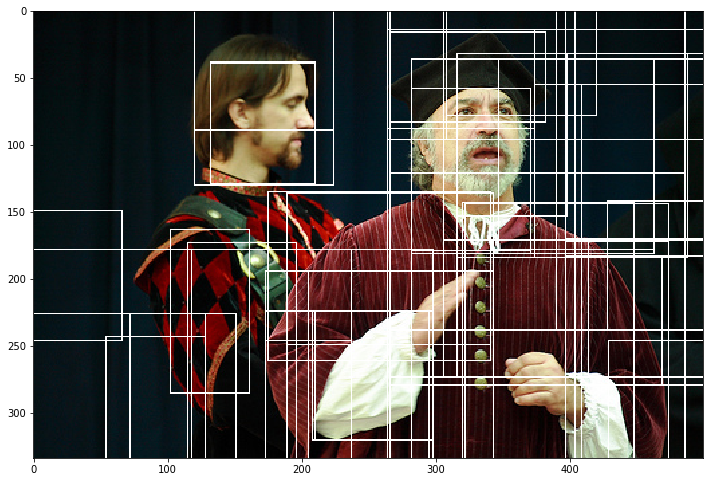

In [7]:
aflw_db_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite'
aflw_dir_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/flickr'
img_path = os.path.join(aflw_dir_path, '3/image03350.jpg')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = selective_search_dlib(img)
rects = aflw.non_max_suppression_fast(np.array(rects), 0.5)

print(len(rects), "regiones propuestas luego de SS/NMS")
count = 0
target_size = 227,227
for rect in rects:    
    p1 = (rect[0], rect[1])
    p2 = (rect[0] + rect[2], rect[1] + rect[3])
    cv2.rectangle(img, p1, p2, (255, 255, 255))

plt.figure(figsize=(12, 12))
plt.imshow(img)

In [3]:
model_weights_file = 'hyperface.squeeze.weights.h5'
model_yaml_file = 'hyperface.squeeze.model.yaml'

yaml_file = open(model_yaml_file, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)
loaded_model.load_weights(model_weights_file)
print("Modelo cargado")

Modelo cargado


67 regiones propuestas luego de SS/NMS


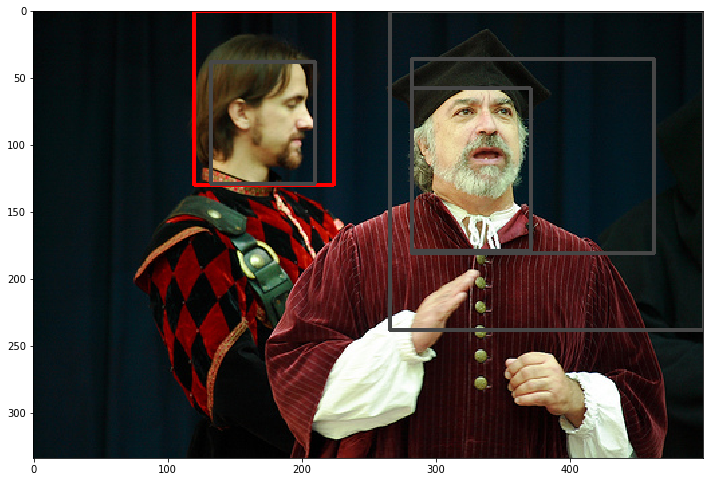

In [109]:
aflw_db_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite'
aflw_dir_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/flickr'
img_path = os.path.join(aflw_dir_path, '3/image03350.jpg')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = selective_search_dlib(img)
rects = aflw.non_max_suppression_fast(np.array(rects), 0.5)

print(len(rects), "regiones propuestas luego de SS/NMS")
count = 0
target_size = 227,227
for rect in rects:    
    bbox = rect[0],rect[1],rect[0]+rect[2],rect[1]+rect[3]

    #print("loading", bbox)
    #rect_img = load_img(img_path, target_size=target_size, bbox=bbox)
    #plt.figure(figsize=(3, 3))
    #plt.imshow(np.asarray(rect_img))

    # cargar imagen y estandarizarla
    img_array = get_img(img_path, target_size, bbox)
    img_array = np.expand_dims(img_array, axis=0)

    # predicción
    preds = loaded_model.predict(img_array)
    # print('face_nonface predicted:')
    # print(preds[0])
    
    # umbral de predicción rostro/no rostro
    if preds[0][0][0] > 0.5:
        # print('gender predicted:')
        # print(preds[4])
        gender = np.argmax(preds[4][0],axis=-1)
        if gender == 0:
            color = (0,0,255)
        elif gender == 1:
            color = (255,0,0)
        else:
            color = (70,70,70)
        p1 = (rect[0], rect[1])
        p2 = (rect[0] + rect[2], rect[1] + rect[3])
        cv2.rectangle(img, p1, p2, color, thickness=2)
        
        """
        print('landmarks predicted:')
        print(preds[1])
        target_w, target_h = target_size
        box_x, box_y, box_w, box_h = rect[0],rect[1],rect[2],rect[3]
        x = preds[1][0][0:21]
        y = preds[1][0][21:42]
        # desnormalizar
        xc, yc = target_w / 2, target_h / 2
        x = x*target_w + xc
        y = y*target_h + yc
        # escalar        
        scale_x = target_w / box_w
        scale_y = target_h / box_h
        x = x / scale_x
        y = y / scale_y
        # trasladar
        x = x + bbox[0]
        y = y + bbox[1]
        print(x)
        print(y)
        for i in range(21):
            #xi,yi=x[i],y[i]
            cv2.circle(img, (x[i], y[i]), 2, (0,255,0))
        """

plt.figure(figsize=(12, 12))
plt.imshow(img)

36 regiones propuestas luego de SS/NMS


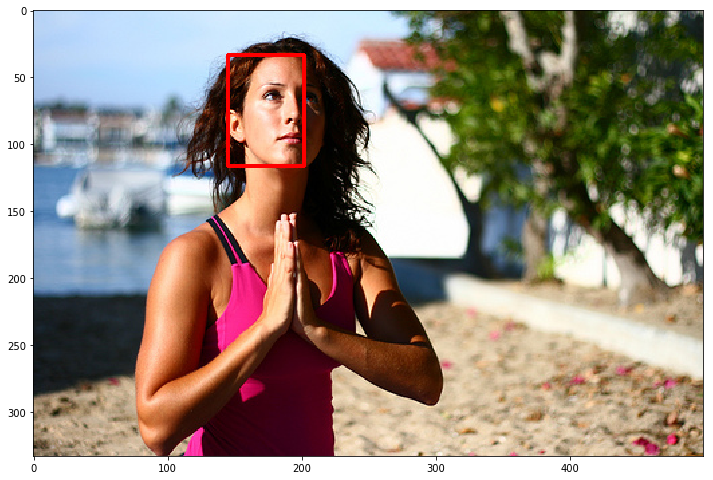

In [108]:
aflw_db_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite'
aflw_dir_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/flickr'
img_path = os.path.join(aflw_dir_path, '3/image03350.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04000.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04016.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04216.jpg')
img_path = os.path.join(aflw_dir_path, '3/image04685.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04018.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04567.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04697.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04699.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04398.jpg') #
#img_path = os.path.join(aflw_dir_path, '3/image04581.jpg') #
#img_path = os.path.join(aflw_dir_path, '3/image04750.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04754.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04096.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04105.jpg')
#img_path = os.path.join(aflw_dir_path, '3/image04786.jpg')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = selective_search_dlib(img)
rects = aflw.non_max_suppression_fast(np.array(rects), 0.5)

print(len(rects), "regiones propuestas luego de SS/NMS")
count = 0
target_size = 227,227
for rect in rects:    
    bbox = rect[0],rect[1],rect[0]+rect[2],rect[1]+rect[3]

    #print("loading", bbox)
    #rect_img = load_img(img_path, target_size=target_size, bbox=bbox)
    #plt.figure(figsize=(3, 3))
    #plt.imshow(np.asarray(rect_img))

    # cargar imagen y estandarizarla
    img_array = get_img(img_path, target_size, bbox)
    img_array = np.expand_dims(img_array, axis=0)

    # predicción
    preds = loaded_model.predict(img_array)
    # print('face_nonface predicted:')
    # print(preds[0])
    
    # umbral de predicción rostro/no rostro
    if preds[0][0][0] > 0.5:
        # print('gender predicted:')
        # print(preds[4])
        gender = np.argmax(preds[4][0],axis=-1)
        if gender == 0:
            color = (0,0,255)
        elif gender == 1:
            color = (255,0,0)
        else:
            color = (70,70,70)
        p1 = (rect[0], rect[1])
        p2 = (rect[0] + rect[2], rect[1] + rect[3])
        cv2.rectangle(img, p1, p2, color, thickness=2)
        
        """
        print('landmarks predicted:')
        print(preds[1])
        target_w, target_h = target_size
        box_x, box_y, box_w, box_h = rect[0],rect[1],rect[2],rect[3]
        x = preds[1][0][0:21]
        y = preds[1][0][21:42]
        # desnormalizar
        xc, yc = target_w / 2, target_h / 2
        x = x*target_w + xc
        y = y*target_h + yc
        # escalar        
        scale_x = target_w / box_w
        scale_y = target_h / box_h
        x = x / scale_x
        y = y / scale_y
        # trasladar
        x = x + bbox[0]
        y = y + bbox[1]
        print(x)
        print(y)
        for i in range(21):
            #xi,yi=x[i],y[i]
            cv2.circle(img, (x[i], y[i]), 2, (0,255,0))
        """

plt.figure(figsize=(12, 12))
plt.imshow(img)